# Testing Predictions Pepper Buetepage

(0.0, 0.21)

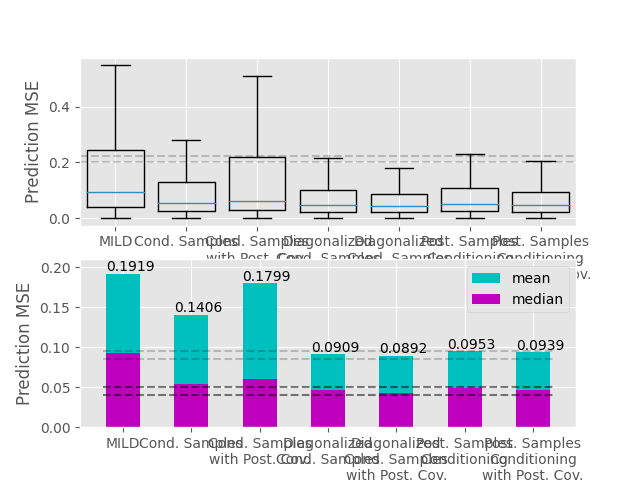

In [23]:
%matplotlib widget
import numpy as np
import scipy
import matplotlib.pyplot as plt
from test import evaluate_ckpt
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

fig = plt.figure()
plt.title('MSE of predicted robot joints after observing human')
ax_box_pred = plt.subplot(2,1,1)
# ax_box_vae = plt.subplot(2,2,2)
ax_bar_pred = plt.subplot(2,1,2)
# ax_bar_vae = plt.subplot(2,2,4)
k = 0

pred_mse = []
for model_type, use_cov in [
                        ('v1_0', False),
                        ('v3_1', False),
                        ('v3_2', True),
                        ('v4_1', False),
                        ('v4_2', True),
                        ('v2_1', False),
                        ('v2_2', True),
                    ]:
    pred_mse_k = []

    for trial in range(4):
        ckpt_path = f'logs/2023/bp_pepper_downsampled_robotfuture_ablation/z05/{model_type}/vanilla/trial{trial}/models/final_100.pth'
        pred_mse_ckpt, _ = evaluate_ckpt(ckpt_path, use_cov)
        pred_mse_k += pred_mse_ckpt
    pred_mse.append(pred_mse_k)
    
    # print(f'{model_name}\t{np.mean(pred_mse):.4e} ± {np.std(pred_mse):.4e} \t{np.mean(vae_mse):.4e} ± {np.std(vae_mse):.4e}')

# p_values = np.ones((len(pred_mse), len(pred_mse)))
# for i in range(len(pred_mse)-1):
#     for j in range(i+1,len(pred_mse)):
#         p_values[i,j] = scipy.stats.ttest_ind(pred_mse[i], pred_mse[j]).pvalue
#         print(i,j,p_values[i,j])

# p_values = np.ones((len(pred_mse), len(pred_mse)))
# for i in range(len(pred_mse)-1):
#     for j in range(i+1,len(pred_mse)):
#         p_values[i,j] = scipy.stats.ttest_rel(pred_mse[i], pred_mse[j]).pvalue
#         print(i,j,p_values[i,j])

# p_values = np.ones((len(pred_mse), len(pred_mse)))
# for i in range(len(pred_mse)-1):
#     for j in range(i+1,len(pred_mse)):
#         p_values[i,j] = scipy.stats.mannwhitneyu(pred_mse[i], pred_mse[j]).pvalue
#         print(i,j,p_values[i,j])


X = np.arange(len(pred_mse))
mean_pred_mse = np.array([np.mean(pred_mse[i]) for i in range(len(pred_mse))])
med_pred_mse = np.array([np.median(pred_mse[i]) for i in range(len(pred_mse))])
ax_bar_pred.bar(X, mean_pred_mse, color = 'c', width = 0.5, label='mean')#, label='100 epochs')
ax_bar_pred.bar(X, med_pred_mse, color = 'm', width = 0.5, label='median')#, label='100 epochs')

for i in [0.085, 0.095]:
    ax_bar_pred.plot([-0.3,len(pred_mse)-0.7], [i,i], 'k--',alpha=0.2)
for i in range(len(mean_pred_mse)):
    ax_bar_pred.text(i-0.25, mean_pred_mse[i]+0.003, f'{mean_pred_mse[i]:.4f}')
for i in range(len(pred_mse)):
    ax_box_pred.boxplot(pred_mse[i], positions=[i], showfliers=False, widths=[0.8])
# ax_bar_pred.bar(X + 0.6, [np.mean(pred_mse[i][1]) for i in range(len(pred_mse))], color = 'm', width = 0.2, label='200 Epochs')
ax_bar_pred.set_ylabel('Prediction MSE')
ax_box_pred.set_ylabel('Prediction MSE')
ax_bar_pred.set_xticks(X, ('MILD', 'Cond. Samples', 'Cond. Samples\nwith Post. Cov.', 'Diagonalized\nCond. Samples', 'Diagonalized\nCond. Samples\nwith Post. Cov.', 'Post. Samples\nConditioning', 'Post. Samples\nConditioning\nwith Post. Cov.', ))
ax_box_pred.set_xticks(X, ('MILD', 'Cond. Samples', 'Cond. Samples\nwith Post. Cov.', 'Diagonalized\nCond. Samples', 'Diagonalized\nCond. Samples\nwith Post. Cov.', 'Post. Samples\nConditioning', 'Post. Samples\nConditioning\nwith Post. Cov.', ))
# ax_bar_pred.set_xticks(X, ('MILD', '#2.1', '#2.2', '#3.1', '#3.2', '#4.1', '#4.2'))
# ax_box_pred.set_xticks(X, ('MILD', '#2.1', '#2.2', '#3.1', '#3.2', '#4.1', '#4.2'))
for i in [0.2,0.225]:
    ax_box_pred.plot([-0.5,len(pred_mse)-0.5], [i,i], 'k--',alpha=0.2)
for i in [0.05, 0.04]:
    ax_bar_pred.plot([-0.3,len(pred_mse)-0.7], [i,i], 'k--',alpha=0.5)
ax_bar_pred.legend()
ax_bar_pred.set_ylim(top=0.21)


# "MILD" - Standard VAE Loss
$$\mathcal{L}_t = \mathbb{E}_{q_h}\log p(\boldsymbol{x}^h_t|\boldsymbol{z}^h_t) + \mathbb{E}_{q_r}\log p(\boldsymbol{x}^r_t|\boldsymbol{z}^r_t) + \mathcal{L}_{KL}$$

The following  use an additional conditional reconstruction term $\mathcal{L}_{cond} = \mathbb{E}\log p(\boldsymbol{x}^r_t|\boldsymbol{\hat{z}}^r_t)$
They mainly differ in how the expectation is calculated w.r.t $\boldsymbol{\hat{z}}^r_t$, specifically which distribution is used for Monte Carlo sampling. We then calculate the reconstruction loss for the sampled points.

# Cond. Samples
- Samples are drawn from the HMM conditional distribution.
- Calculate the posterior distribution $\boldsymbol{\mu}_{\boldsymbol{z}}(\boldsymbol{x}^h_t),\boldsymbol{\Sigma}_{\boldsymbol{z}}(\boldsymbol{x}^h_t) = q(\boldsymbol{z}^h_t|\boldsymbol{x}^h_t)$
- Calculate the conditional distribution using the posterior mean and sample $\boldsymbol{\hat{z}}^r_t$ from this.
$$
  \boldsymbol{K}_i = {\color{orange}\boldsymbol{\Sigma}^{rh}_i}({\color{orange}\boldsymbol{\Sigma}^{hh}_i})^{-1} \\
    \boldsymbol{\hat{\mu}}^r_i = {\color{orange}\boldsymbol{\mu}^{r}_i} + \boldsymbol{K}_i({\color{orange}\boldsymbol{\mu}^h_i} - {\color{magenta}\boldsymbol{\mu}_{\boldsymbol{z}}(\boldsymbol{x}^h_t)})\\
    \boldsymbol{\hat{\Sigma}}^r_i = {\color{orange}\boldsymbol{\Sigma}^{rr}_i} - \boldsymbol{K}_i{\color{orange}\boldsymbol{\Sigma}^{hr}_i} + \boldsymbol{\hat{\mu}}^r_i(\boldsymbol{\hat{\mu}}^r_i)^T\\
    \boldsymbol{\hat{\mu}}^r_t = \sum_{i=1}^N {\color{orange}\bar \alpha_i^t} \hspace{0.2em} \boldsymbol{\hat{\mu}}^r_i\\
    \boldsymbol{\hat{\Sigma}}^r_t = \left[\sum_{i=1}^N {\color{orange}\bar \alpha_i^t} \hspace{0.2em} \boldsymbol{\hat{\Sigma}}^r_i\right]  - \boldsymbol{\hat{\mu}}^r_t(\boldsymbol{\hat{\mu}}^r_t)^T\\
    p(\boldsymbol{z}_t^r | q_t^h) = \mathcal{N}(\boldsymbol{z}^r_t;\boldsymbol{\hat{\mu}}^r_t, \boldsymbol{\hat{\Sigma}}^r_t) \\
    \mathcal{L}_{cond} = \mathbb{E}_{\boldsymbol{\hat{z}}^r_t \sim p(\boldsymbol{z}_t^r | q_t^h)}\log p(\boldsymbol{x}^r_t|\boldsymbol{\hat{z}}^r_t)
$$

# Diagonalized Cond. Samples
Same as above but using the diagonalized form of the conditional distribution covariance
$$p(\boldsymbol{z}_t^r | q_t^h) = \mathcal{N}(\boldsymbol{z}^r_t;\boldsymbol{\hat{\mu}}^r_t, diag(\boldsymbol{\hat{\Sigma}}^r_t))$$

# Posterior Sample Conditioning 
$$
{\color{magenta}\boldsymbol{z}^h_t} \sim q(\boldsymbol{z}^h_t|\boldsymbol{x}^h_t)\\
\boldsymbol{K}_i = {\color{orange}\boldsymbol{\Sigma}^{rh}_i}({\color{orange}\boldsymbol{\Sigma}^{hh}_i})^{-1} \\
    \boldsymbol{\hat{z}}^r_t = \sum_{k=1}^K {\color{orange}\bar \alpha_i^t} [{\color{orange}\boldsymbol{\mu}^{r}_i} + \boldsymbol{K}_i({\color{orange}\boldsymbol{\mu}^h_i} - {\color{magenta}\boldsymbol{z}^h_t})]\\
    \mathcal{L}_{cond} = \mathbb{E}_{\boldsymbol{\hat{z}}^r_t| \boldsymbol{z}^h_t \sim q(\boldsymbol{z}^h_t | \boldsymbol{x}^h_t)}\log p(\boldsymbol{x}^r_t|\boldsymbol{\hat{z}}^r_t)
$$


# "with Post. Cov."
This implies Conditioning with the Posterior Covariance
$$\boldsymbol{K}_i = {\color{orange}\boldsymbol{\Sigma}^{rh}_i}({\color{orange}\boldsymbol{\Sigma}^{hh}_i} + {\color{magenta}\boldsymbol{\Sigma}_{\boldsymbol{z}}(\boldsymbol{x}^h_t)})^{-1}$$